In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pypsa

from plotting_constants import nice_names, color_dict

In [4]:
day = '2024-03-21'

In [5]:
sc = pd.read_csv(Path.cwd().parent / 'results' / f'{day}' /  'system_cost_summary_flex.csv', index_col=[0,1], parse_dates=[0])

In [6]:
if day != 'total':
    fn_nat = str(Path.cwd().parent / 'results' / '{}'  / 'bmu_revenues_flex_{}.csv').format(day, 'national')
    fn_zonal = str(Path.cwd().parent / 'results' / '{}'  / 'bmu_revenues_flex_{}.csv').format(day, 'zonal')
else:
    fn_nat = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_{}.csv').format('national')
    fn_zonal = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_{}.csv').format('zonal')

In [7]:
nat = pd.read_csv(
    fn_nat,
    index_col=0,
    header=[0,1,2],
    parse_dates=True
)
zon = pd.read_csv(
    fn_zonal,
    index_col=0,
    header=[0,1,2],
    parse_dates=True
)

In [ ]:
nat_who = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_national_solved.nc'
)
nat_bal = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_national_solved_redispatch.nc'
)
zon_who = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_zonal_solved.nc'
)
zon_bal = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_zonal_solved_redispatch.nc'
)

INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads
INFO:pypsa.io:Imported network network_flex_s_zonal_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_zonal_solved_redispatch.nc has buses, carriers, generators, links, loads


In [9]:
zon_who.buses_t.marginal_price.iloc[20].value_counts()

2024-03-21 10:00:00
 80.659588    225
-58.070776     59
 58.286743      2
 54.268445      1
 40.971220      1
 56.684565      1
Name: count, dtype: int64

In [10]:
import geopandas as gpd

gb = gpd.read_file(Path.cwd().parent / 'data' / 'GB_shape.geojson').set_index('name')

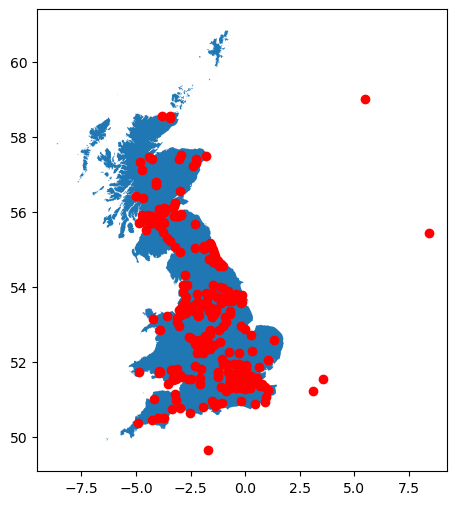

In [11]:
gdf = gpd.GeoDataFrame(
        zon_who.buses,
        geometry=gpd.points_from_xy(
            zon_who.buses['x'], zon_who.buses['y']
            )
        ).set_crs('EPSG:4326')
    
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

gb.plot(ax=ax)
gdf.plot(ax=ax, color='r')

plt.show()

mask = gdf.within(gb.loc['GB', 'geometry'])
    
gb_buses = zon_who.buses.index[mask]

In [12]:
zon_who.buses_t.marginal_price.loc[:,gb_buses].iloc[10].value_counts()

2024-03-21 05:00:00
 61.060775    225
-58.070776     59
Name: count, dtype: int64

In [13]:
zon_who.buses

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country
Bus,,,,,,,,,,,,,
8838,380.0,,-2.169800,53.243852,AC,,1.0,0.0,inf,PQ,,,GB
8013,380.0,,-2.270050,57.410941,AC,,1.0,0.0,inf,PQ,,,GB
8649,380.0,,-1.724854,52.571342,AC,,1.0,0.0,inf,PQ,,,GB
4950,380.0,,0.303497,52.288323,AC,,1.0,0.0,inf,PQ,,,GB
4951,380.0,,0.045319,51.928178,AC,,1.0,0.0,inf,PQ,,,GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Netherlands,380.0,,3.560000,51.530000,electricity,,1.0,0.0,inf,PQ,,,Netherlands
France,380.0,,-1.710000,49.640000,electricity,,1.0,0.0,inf,PQ,,,France
Belgium,380.0,,3.120000,51.230000,electricity,,1.0,0.0,inf,PQ,,,Belgium


In [14]:
roc = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'roc_values.csv', index_col=0)

cfd = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'cfd_strike_prices.csv', index_col=0)
cfd.columns = pd.to_datetime(cfd.columns)
cfd = cfd.loc[:,:day].iloc[:,-1]

In [29]:
def get_unit_revenues(unit, who, bal):
    """
    Calculate revenue timeseries for a generation unit from multiple sources.
    
    Parameters:
    - unit: Generator name/ID
    - who: Wholesale market model network
    - bal: Balancing market model network
    
    Returns:
    - DataFrame with timeseries of revenue components
    """
    # Time step in hours (half-hourly)
    dt = 0.5
    
    # Initialize dataframe with snapshots as index
    snapshots = who.snapshots
    revenues = pd.DataFrame(index=snapshots, columns=[
        'wholesale', 'roc', 'cfd', 'transmission_congestion_credits', 'offer_cost', 'bid_cost', 'total'
    ], data=0.0)
    
    # 1. Wholesale market revenue
    who_dispatch = who.generators_t.p[unit] if unit in who.generators_t.p else pd.Series(0, index=snapshots)
    who_prices = who.buses_t.marginal_price[who.generators.loc[unit, 'bus']]
    revenues['wholesale'] = who_dispatch * who_prices * dt
    
    bal_dispatch = bal.generators_t.p[unit] if unit in bal.generators_t.p else pd.Series(0, index=snapshots)

    # 2. ROC revenue (if applicable)
    if unit in roc.index:
        roc_value = roc.loc[unit, 'roc_value']
        revenues['roc'] = bal_dispatch * roc_value * dt
    
    # 3. CfD revenue (if applicable)
    if 'cfd' in globals() and unit in cfd.index:
        strike_price = cfd.loc[unit]
        
        # Check for negative price periods (at least 6 hours)
        negative_price_periods = who_prices < 0
        # Create a rolling window of 12 periods (6 hours with half-hourly data)
        rolling_negative = negative_price_periods.rolling(window=12).sum()
        # Identify snapshots where we shouldn't pay topup (preceded by 6+ hours of negative prices)
        no_topup_periods = rolling_negative >= 12
        
        # Calculate CfD top-up only for eligible periods
        topup_rates = strike_price - who_prices
        # Set topup to zero for periods following 6+ hours of negative prices
        topup_rates[no_topup_periods] = 0
        
        revenues['cfd'] = topup_rates * bal_dispatch * dt
    
    # 4. FTR revenue
    if len(who.buses) >= 20:
        # Get the unit's bus
        unit_bus = who.generators.loc[unit, 'bus']
        
        # For each timestep, check if there are exactly two unique prices
        for snapshot in snapshots:
            # Get unique prices across all buses for this snapshot
            unique_prices = who.buses_t.marginal_price.loc[:, gb_buses].loc[snapshot].unique()
            
            high_price = max(unique_prices)
            
            unit_price = who.buses_t.marginal_price.loc[snapshot, unit_bus]
            price_diff = abs(high_price - unit_price)
            
            # If unit is in the lower price zone, it gets FTR revenue
            revenues.loc[snapshot, 'transmission_congestion_credits'] = who_dispatch[snapshot] * price_diff * dt
    
    # 5. Balancing revenue (if dispatch differs between models)
    if unit in bal.generators_t.p and unit in who.generators_t.p:
        dispatch_diff = bal.generators_t.p[unit] - who.generators_t.p[unit]
        bal_prices = bal.buses_t.marginal_price[bal.generators.loc[unit, 'bus']]
        
        # Calculate separately for up and down balancing
        up_balancing = dispatch_diff.clip(lower=0)
        down_balancing = dispatch_diff.clip(upper=0)
        
        # Balancing offers (turning up)
        up_revenue = up_balancing * bal_prices * dt
        
        # Apply ROC and CfD adjustments for turning up
        if unit in roc.index:
            roc_value = roc.loc[unit, 'roc_value']
            # For turning up, they would pay their ROC value
            up_revenue -= up_balancing * roc_value * dt
        
        if unit in cfd.index:
            strike_price = cfd.loc[unit]
            # For turning up, they would pay their topup
            topup_rates = strike_price - who_prices
            up_revenue -= up_balancing * topup_rates * dt

        revenues['offer_cost'] = up_revenue

        # Apply ROC and CfD adjustments for turning down
        if unit in roc.index:
            roc_value = roc.loc[unit, 'roc_value']
            # For turning down, they receive their ROC value per MWh curtailed
            down_revenue = down_balancing.abs() * roc_value * dt  # Negative * negative = positive

        if unit in cfd.index:
            strike_price = cfd.loc[unit]
            # For turning down, they are forgoing their topup, so they get paid for that
            topup_rates = strike_price - who_prices
            down_revenue = down_balancing.abs() * topup_rates * dt  # Negative * positive = negative

        revenues['bid_cost'] = down_revenue
    
    # Calculate total revenue
    revenues['total'] = revenues.sum(axis=1)

    return revenues


In [44]:
# Get offshore wind generators from both networks
offshore_wind_who = nat_who.generators[nat_who.generators.carrier.isin(['onwind', 'offwind'])]
offshore_wind_bal = nat_bal.generators[nat_bal.generators.carrier.isin(['onwind', 'offwind'])]

# Get the dispatch for each generator in both networks
who_dispatch = {}
bal_dispatch = {}
deviations = {}

for gen in offshore_wind_who.index:
    if gen in nat_who.generators_t.p.columns:
        who_dispatch[gen] = nat_who.generators_t.p[gen].sum() * 0.5

for gen in offshore_wind_bal.index:
    if gen in nat_bal.generators_t.p.columns:
        bal_dispatch[gen] = nat_bal.generators_t.p[gen].sum() * 0.5

# Calculate deviations between the two models
for gen in who_dispatch:
    if gen in bal_dispatch:
        deviations[gen] = abs(who_dispatch[gen] - bal_dispatch[gen])

# Get the bus coordinates for each generator
gen_bus_info = {}
for gen in deviations:
    bus_id = nat_bal.generators.loc[gen, 'bus']
    y_coord = nat_bal.buses.loc[bus_id, 'y']
    gen_bus_info[gen] = {
        'bus': bus_id,
        'latitude': y_coord,
        'deviation': deviations[gen]
    }

# Group generators by bus
bus_generators = {}
for gen, info in gen_bus_info.items():
    bus_id = info['bus']
    if bus_id not in bus_generators:
        bus_generators[bus_id] = []
    bus_generators[bus_id].append(gen)

# Sort buses by latitude (descending)
sorted_buses = sorted(bus_generators.keys(), 
                     key=lambda bus: nat_bal.buses.loc[bus, 'y'],
                     reverse=True)

# choice = 'GORDW-1' # ROC (21.03.2024)
# choice = 'ABRTW-1' # curtailing ROC (21.03.2024)
# choice = 'HOWAO-2' #CfD  (19.03.2024)
choice = 'DOREW-1' # curtailing CfD (21.03.2024)

# Print results by bus, sorted by latitude
print("Offshore wind generator dispatch deviations by bus (sorted by latitude):")
print("-" * 100)
print(f"{'Bus':<10} {'Latitude':<12} {'Generator':<15} {'Deviation (MWh)':<15} {'Support Type':<16}")
print("-" * 100)

for bus in sorted_buses:
    bus_lat = nat_bal.buses.loc[bus, 'y']
    for i, gen in enumerate(bus_generators[bus]):
        # Determine support type
        if 'roc' in globals() and gen in roc.index:
            support_type = "ROC"
        elif 'cfd' in globals() and gen in cfd.index:
            support_type = "CfD"
        else:
            support_type = "None"
            
        if i == 0:
            # Print bus info only for the first generator of each bus
            print(f"{bus:<10} {bus_lat:<12.6f} {gen:<15} {deviations[gen]:<15.2f} {support_type:<16}")
        else:
            # For other generators of the same bus, don't repeat bus info
            print(f"{'':<10} {'':<12} {gen:<15} {deviations[gen]:<15.2f} {support_type:<16}")
    print("-" * 100)

Offshore wind generator dispatch deviations by bus (sorted by latitude):
----------------------------------------------------------------------------------------------------
Bus        Latitude     Generator       Deviation (MWh) Support Type    
----------------------------------------------------------------------------------------------------
6441       58.546761    ABRTW-1         501.00          ROC             
                        GORDW-1         0.00            ROC             
                        GORDW-2         748.20          ROC             
                        KILBW-1         0.00            ROC             
                        STRNW-1         725.06          ROC             
----------------------------------------------------------------------------------------------------
6443       58.490823    CMSTW-1         0.00            ROC             
                        BNWKW-1         0.00            ROC             
                        HALSW-1         

In [51]:
sc.loc[~sc.index.get_level_values(1).isin(['balancing_volume', 'congestion_rent'])].sum()

nodal       71.820094
zonal       69.839690
national    87.016601
dtype: float64

In [41]:
from tqdm import tqdm

roc_rev_nat = pd.Series(0, index=nat_who.snapshots)
roc_rev_zon = pd.Series(0, index=zon_who.snapshots)

for bus in tqdm(sorted_buses):
    bus_lat = nat_bal.buses.loc[bus, 'y']

    for i, gen in enumerate(bus_generators[bus]):

        if nat_who.generators_t.p[gen].sum() != zon_who.generators_t.p[gen].sum():
            continue

        if gen in roc.index:
            roc_rev_nat += get_unit_revenues(gen, nat_who, nat_bal).mul(1e-3)['total']
            roc_rev_zon += get_unit_revenues(gen, zon_who, zon_bal).mul(1e-3)['total']

100%|██████████| 42/42 [00:04<00:00, 10.12it/s]


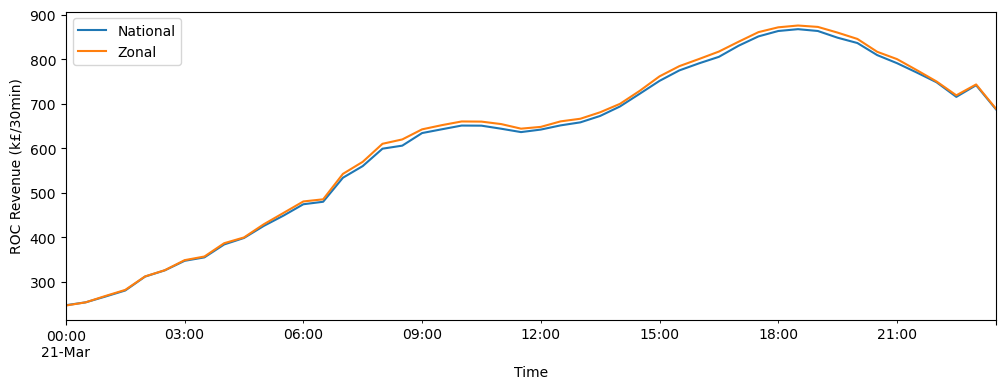

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

roc_rev_nat.plot(ax=ax, label='National')
roc_rev_zon.plot(ax=ax, label='Zonal')

ax.set_ylabel('ROC Revenue (k£/30min)')
ax.set_xlabel('Time')

ax.legend()
plt.show()

In [25]:
color_dict['roc'] = color_dict['roc_payments']
color_dict['cfd'] = color_dict['cfd_payments']
color_dict['transmission_congestion_credits'] = color_dict['congestion_rent']
color_dict

{'wholesale': '#F78C6B',
 'wholesale selling': '#F78C6B',
 'wholesale buying': '#c3763c',
 'roc_payments': '#EF476F',
 'cfd_payments': '#06D6A0',
 'congestion_rent': '#FFD166',
 'offer_cost': '#073B4C',
 'bid_cost': '#118AB2',
 'roc': '#EF476F',
 'cfd': '#06D6A0',
 'transmission_congestion_credits': '#FFD166'}

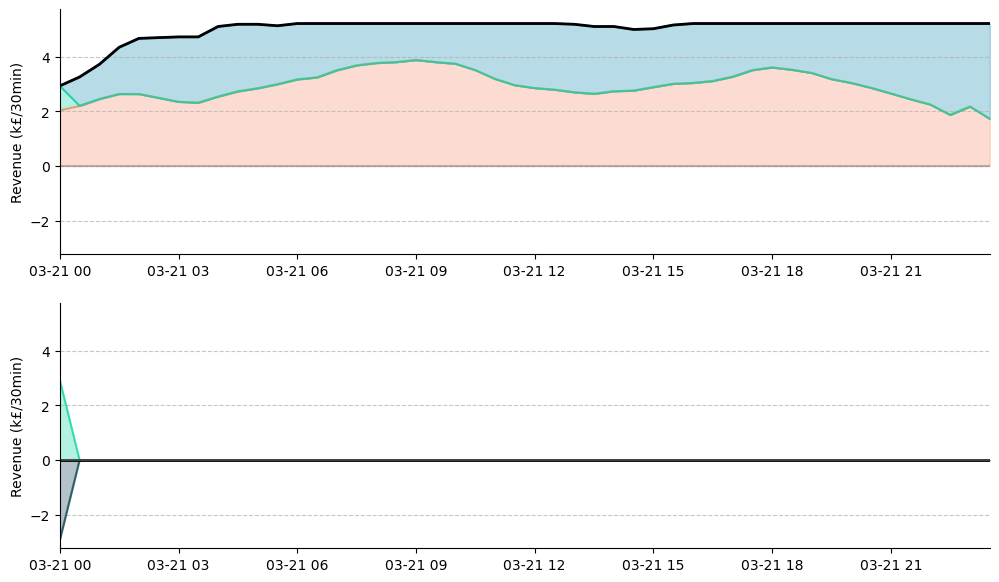

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

nat_rev = get_unit_revenues(choice, nat_who, nat_bal).mul(1e-3)
zon_rev = get_unit_revenues(choice, zon_who, zon_bal).mul(1e-3)

global_y_min = min(nat_rev.drop(columns=['total']).clip(upper=0).sum(axis=1).min(), zon_rev.drop(columns=['total']).clip(upper=0).sum(axis=1).min())
global_y_max = max(nat_rev.drop(columns=['total']).clip(lower=0).sum(axis=1).max(), zon_rev.drop(columns=['total']).clip(lower=0).sum(axis=1).max())
global_y_range = [global_y_min * 1.1, global_y_max * 1.1]

for ax, rev in zip(axs, [nat_rev, zon_rev]):
    ax.set_ylim(global_y_range)

    columns_to_plot = rev.columns[:6]
    base = global_y_min

    pos_cols = [col for col in columns_to_plot if (rev[col] >= 0).any()]
    neg_cols = [col for col in columns_to_plot if (rev[col] < 0).any()]

    pos_stack = pd.DataFrame(0, index=rev.index, columns=pos_cols)
    for col in pos_cols:
        pos_stack[col] = rev[col].clip(lower=0)  # Only keep positive values

    # Create cumulative sums for stacking
    pos_cumsum = pos_stack.cumsum(axis=1)

    # Plot each positive column as stacked area
    for i, col in enumerate(pos_cols):

        if rev[col].clip(lower=0).sum() == 0:
            continue

        # Calculate bottom of current stack
        bottom = 0 if i == 0 else pos_cumsum[pos_cols[i-1]]
        top = pos_cumsum[col]

        ax.fill_between(
            rev.index,
            bottom,
            top,
            alpha=0.3,
            label=col,
            color=color_dict[col]
        )
        ax.plot(
            rev.index,
            top,
            alpha=0.7,
            color=color_dict[col]
        )

    # Plot negative values stacked on each other
    neg_stack = pd.DataFrame(0, index=rev.index, columns=neg_cols)
    for col in neg_cols:
        neg_stack[col] = rev[col].clip(upper=0)  # Only keep negative values

    # Create cumulative sums for stacking
    neg_cumsum = neg_stack.cumsum(axis=1)

    # Plot each negative column as stacked area
    for i, col in enumerate(neg_cols):

        if rev[col].clip(upper=0).sum() == 0:
            continue

        # Calculate bottom of current stack
        bottom = 0 if i == 0 else neg_cumsum[neg_cols[i-1]]
        top = neg_cumsum[col]

        ax.fill_between(
            rev.index,
            bottom,
            top,
            alpha=0.3,
            label=col if col not in pos_cols else f"{col} (neg)",
            color=color_dict[col]
        )
        ax.plot(
            rev.index,
            top,
            alpha=0.7,
            color=color_dict[col]
        )
    # Plot total line
    ax.plot(rev.index, rev['total'], color='black', linewidth=2, label='Total')
    ax.set_xlim(rev.index[0], rev.index[-1])

    # Add horizontal line at y=0
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.set_ylabel('Revenue (k£/30min)')

plt.show()

<Axes: xlabel='snapshot'>

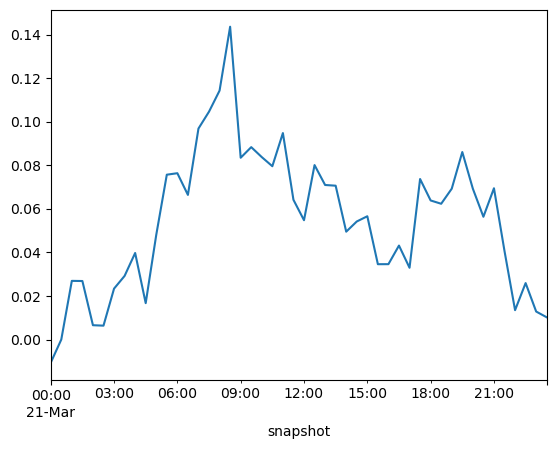

In [19]:
(zon_rev['total'] - nat_rev['total']).rename('difference').plot()